In [2]:
import pandas as pd
import numpy as np
import pm4py
from matplotlib import pyplot as plt
import seaborn as sns
from fitter import Fitter
import scipy.stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [7]:
def quantile2(column,pct,pct_lower):
    y = column
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return y

### Importazione dataset

In [3]:
df_traces = pd.read_csv('C:/Users/HP/Desktop/df_traces_from_weigh.csv')
df_traces.drop('Unnamed: 0', axis=1, inplace=True)

df_t_est = pd.read_csv('C:/Users/HP/Desktop/df_t_est.csv')
df_t_est.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
len(df_traces['ID_unique'].unique())

1580

event_log = df_traces[['ID', 'stato', 'ubicazione', 'rif', 'ID_unique', 'timestamp']]
event_log.sort_values(['ID', 'timestamp'], inplace=True)
event_log.reset_index(inplace=True, drop=True)
event_log = pm4py.format_dataframe(event_log, case_id='ID_unique', activity_key='rif', timestamp_key='timestamp')

In [59]:
event_log = df_traces[['cono', 'rif', 'ID_unique', 'timestamp']]
event_log.sort_values(['cono', 'timestamp'], inplace=True)
event_log.reset_index(inplace=True, drop=True)
event_log = pm4py.format_dataframe(event_log, case_id='ID_unique', activity_key='rif', timestamp_key='timestamp')

In [60]:
len(event_log['ID_unique'].unique())

1580

### Calcolo tempi di interarrivo

In [61]:
df_int = event_log[event_log['rif'] == 'V_da_pes/pesatura']

In [62]:
#df_int.drop_duplicates(subset='ID_unique', inplace=True)

In [63]:
df_int.sort_values('timestamp', inplace=True)
df_int.reset_index(drop=True, inplace=True)

In [66]:
intervals = []

for i in range(len(df_int) - 1):
    time_delta = df_int.loc[i + 1, 'timestamp'] - df_int.loc[i, 'timestamp']
    dt = time_delta.total_seconds() / 60
    intervals.append(dt)

In [67]:
len(intervals)

2238

In [68]:
intervals = quantile2(intervals,0.95,0)

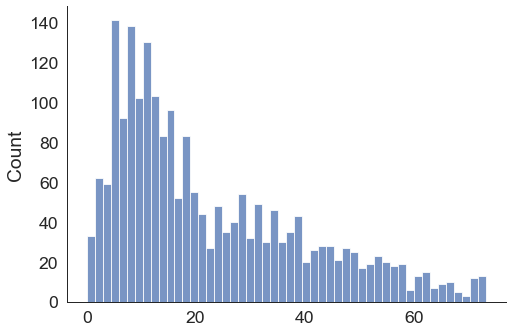

In [69]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=intervals, kind="hist", bins = 50, aspect = 1.5)

,sumsquare_error,aic,bic,kl_div
exponnorm,0.004028,959.161971,-27990.283173,inf
laplace_asymmetric,0.004217,960.785221,-27892.817363,inf
fatiguelife,0.004257,960.563155,-27872.598437,inf
recipinvgauss,0.004275,958.755883,-27863.472542,inf
wald,0.004277,963.110953,-27870.403317,inf


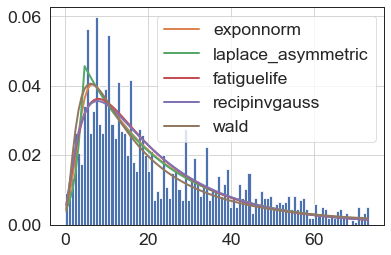

In [70]:
#  extract best fitting distribution
f = Fitter(intervals)
f.fit()
f.summary()

In [71]:
f.get_best(method = 'sumsquare_error')

{'exponnorm': {'K': 9.705803684825007,
  'loc': 2.97487585040842,
  'scale': 2.0300493854781405}}

### Pre processing

In [6]:
#  remove traces with 'recheck' as activity
'''mask_recheck = np.asarray( event_log[ event_log['stato'] == 'P_recheck' ].index )
ID_recheck = event_log.loc[mask_recheck]['ID_unique'].values
mask_drop_recheck = np.asarray( event_log[ event_log['ID_unique'].isin(ID_recheck)].index )
event_log.drop( mask_drop_recheck, inplace = True )'''

#  visualize start/end activities
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'V_da_pes/pesatura': 1580}
End activities: {'V_per_park/estrusore': 1474, 'V_da_pes/estrusore': 94, 'Not_def/fuori_impianto': 3, 'V_da_pes/pesatura': 2, 'P_da_est/estrusore': 2, 'V_per_park/catenaria_parcheggi': 2, 'P_da_est/buffer': 1, 'V_per_park/carroponte_2': 1, 'V_per_park/fuori_impianto': 1}


In [7]:
#  filtering event log by start activiy
from pm4py.algo.filtering.pandas.start_activities import start_activities_filter
event_log = start_activities_filter.apply(event_log, ['V_da_pes/pesatura'],
                                          parameters={start_activities_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      start_activities_filter.Parameters.ACTIVITY_KEY: "concept:name"})
pm4py.get_start_activities(event_log)

{'V_da_pes/pesatura': 1580}

In [8]:
#  filtering event log by end activiy
from pm4py.algo.filtering.pandas.end_activities import end_activities_filter
event_log = end_activities_filter.apply(event_log, ['V_per_park/estrusore', 'V_da_pes/estrusore'],
                                          parameters={end_activities_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      end_activities_filter.Parameters.ACTIVITY_KEY: "concept:name"})
pm4py.get_end_activities(event_log)

{'V_per_park/estrusore': 1474, 'V_da_pes/estrusore': 94}

In [9]:
#  fitering event log removing reworked traces
df_rework = pm4py.filter_activities_rework(event_log, "V_da_pes/catenaria_ing_misc", 2)
event_log.drop( df_rework.index, inplace = True )

### Process mining

In [10]:
#  evaluate number of variants
from pm4py.statistics.traces.generic.pandas import case_statistics
variants_count = case_statistics.get_variant_statistics(event_log,
                                          parameters={case_statistics.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      case_statistics.Parameters.ACTIVITY_KEY: "concept:name",
                                                      case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"})
variants_count = sorted(variants_count, key=lambda x: x['case:concept:name'], reverse=True)
len(variants_count)

294

In [11]:
variants_count

[{'variant': 'V_da_pes/pesatura,P_da_misc/pesatura,P_da_misc/miscelatore,P_da_est/miscelatore,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/buffer,P_da_est/estrusore,V_per_park/estrusore',
  'case:concept:name': 269},
 {'variant': 'V_da_pes/pesatura,P_da_misc/pesatura,P_da_misc/miscelatore,P_da_est/miscelatore,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/estrusore,V_per_park/estrusore',
  'case:concept:name': 259},
 {'variant': 'V_da_pes/pesatura,P_da_misc/pesatura,P_da_misc/miscelatore,P_da_est/miscelatore,P_da_est/cat_usc_pieni,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/estrusore,V_per_park/estrusore',
  'case:concept:name': 234},
 {'variant': 'V_da_pes/pesatura,P_da_misc/pesatura,P_da_misc/miscelatore,P_da_est/miscelatore,P_da_est/cat_usc_pieni,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/buffer,P_da_est/estrusore,V_per_park/estrusore',
  'case:concept:name': 205},
 {'variant': 'V_da_pes/pesatura,P_da_misc/pesatura,P_da_mi

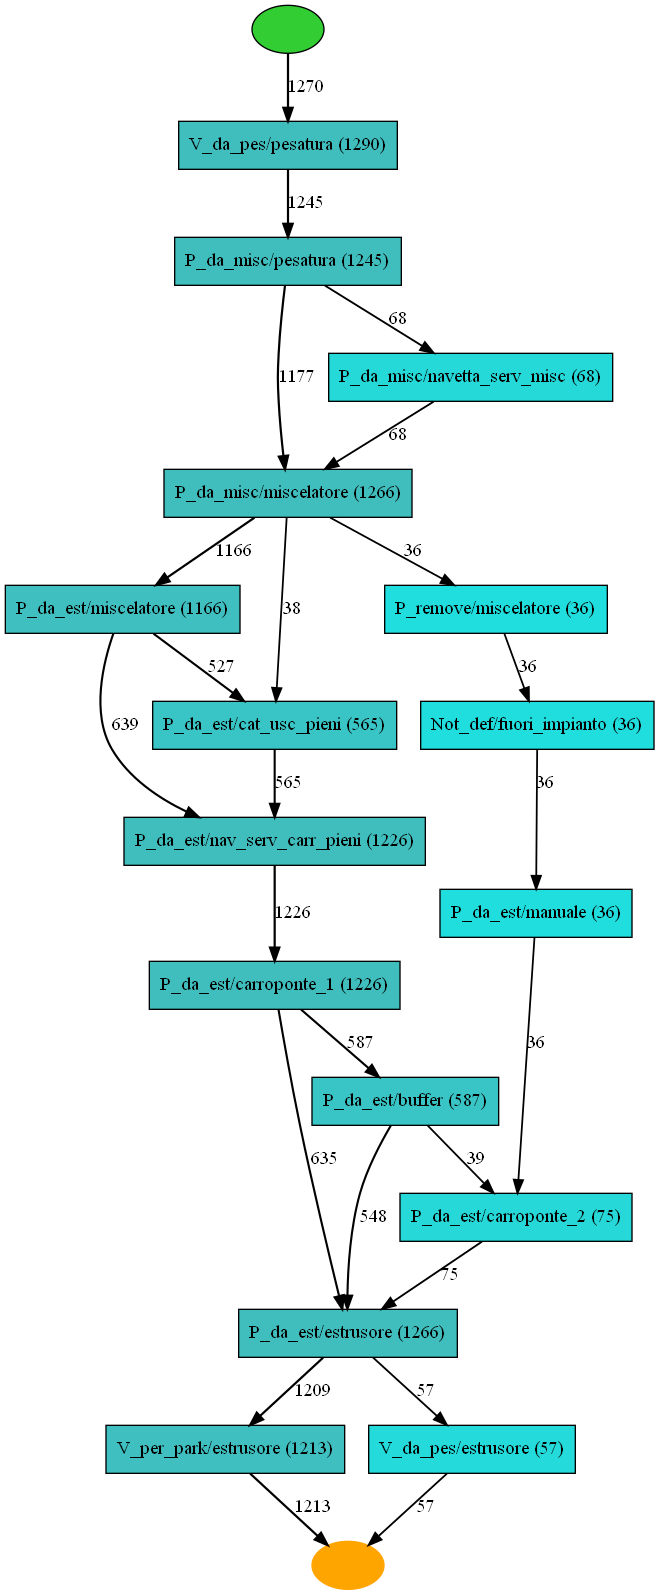

In [12]:
#  take most significant variants
filtered_log = pm4py.filter_variants_top_k(event_log, 30)

#  visualize heuristic net
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
heu_net = heuristics_miner.apply_heu(filtered_log,
                                     parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 1,
                                                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 1,
                                                heuristics_miner.Variants.CLASSIC.value.Parameters.LOOP_LENGTH_TWO_THRESH: 2})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [13]:
pm4py.save_vis_heuristics_net(heu_net, 'C:/Users/HP/Desktop/huristicnet_post_pes.png')

In [14]:
filtered_log

,cono,rif,ID_unique,timestamp,case:concept:name,concept:name,time:timestamp,@@index
0,1,V_da_pes/pesatura,0C1,2022-03-23 01:54:52+00:00,0C1,V_da_pes/pesatura,2022-03-23 01:54:52+00:00,0
1,1,P_da_misc/pesatura,0C1,2022-03-23 02:09:10+00:00,0C1,P_da_misc/pesatura,2022-03-23 02:09:10+00:00,1
2,1,P_da_misc/miscelatore,0C1,2022-03-23 02:11:28+00:00,0C1,P_da_misc/miscelatore,2022-03-23 02:11:28+00:00,2
3,1,P_da_est/miscelatore,0C1,2022-03-23 02:13:45+00:00,0C1,P_da_est/miscelatore,2022-03-23 02:13:45+00:00,3
4,1,P_da_est/cat_usc_pieni,0C1,2022-03-23 02:14:54+00:00,0C1,P_da_est/cat_usc_pieni,2022-03-23 02:14:54+00:00,4
...,...,...,...,...,...,...,...,...
4685,7,P_da_est/miscelatore,9C7,2022-03-30 14:22:54+00:00,9C7,P_da_est/miscelatore,2022-03-30 14:22:54+00:00,4685
4686,7,P_da_est/nav_serv_carr_pieni,9C7,2022-03-30 14:25:11+00:00,9C7,P_da_est/nav_serv_carr_pieni,2022-03-30 14:25:11+00:00,4686
4687,7,P_da_est/carroponte_1,9C7,2022-03-30 14:26:54+00:00,9C7,P_da_est/carroponte_1,2022-03-30 14:26:54+00:00,4687
4688,7,P_da_est/estrusore,9C7,2022-03-30 14:28:37+00:00,9C7,P_da_est/estrusore,2022-03-30 14:28:37+00:00,4688


### Calcolo intertempi tra le attività

In [15]:
delta_t_est = {'pesatura': [],
              'hand_to_misc': [],
              'miscelazione': [],
              'hand_to_est':[],
              'estrusione': []}

df_est = filtered_log[['ID_unique', 'rif', 'timestamp']].copy()

In [16]:
for idu in df_est['ID_unique'].unique():
    mask = df_est['ID_unique'] == idu
    df_tmp = df_est[mask].sort_values('timestamp')
    df_tmp.set_index('rif', inplace=True)
    if len(df_tmp) == len(df_tmp.index.unique()):
        for k in delta_t_est:
            minuendo = None
            sottraendo = None
            if k == 'pesatura':
                if 'P_da_misc/pesatura' in df_tmp.index:
                    minuendo = 'P_da_misc/pesatura'
                    sottraendo = 'V_da_pes/pesatura'
                else:
                    continue
                #-----------
            elif k == 'hand_to_misc':
                if 'P_da_misc/pesatura' in df_tmp.index:
                    minuendo = 'P_da_misc/miscelatore'
                    sottraendo = 'P_da_misc/pesatura'
                else:
                    continue
                #-----------
            elif k == 'miscelazione':
                if 'P_remove/miscelatore' in df_tmp.index:
                    minuendo = 'P_remove/miscelatore'
                    sottraendo = 'P_da_misc/miscelatore'
                elif 'P_da_est/miscelatore' in df_tmp.index:
                    minuendo = 'P_da_est/miscelatore'
                    sottraendo = 'P_da_misc/miscelatore'
                #----------------
            elif k == 'hand_to_est':
                if 'P_da_est/buffer' in df_tmp.index and 'P_da_est/cat_usc_pieni' in df_tmp.index:
                    minuendo = 'P_da_est/buffer'
                    sottraendo = 'P_da_est/cat_usc_pieni'
                elif 'P_da_est/buffer' in df_tmp.index and 'P_da_est/miscelatore' in df_tmp.index and 'P_da_est/cat_usc_pieni' not in df_tmp.index:
                    minuendo = 'P_da_est/buffer'
                    sottraendo = 'P_da_est/miscelatore'
                elif 'P_da_est/estrusore' in df_tmp.index and 'P_da_est/cat_usc_pieni' in df_tmp.index and 'P_da_est/buffer' not in df_tmp.index:
                    minuendo = 'P_da_est/estrusore'
                    sottraendo = 'P_da_est/cat_usc_pieni'
                elif 'P_da_est/estrusore' in df_tmp.index and 'P_da_est/miscelatore' in df_tmp.index and 'P_da_est/cat_usc_pieni' not in df_tmp.index and 'P_da_est/buffer' not in df_tmp.index:
                    minuendo = 'P_da_est/estrusore'
                    sottraendo = 'P_da_est/miscelatore'
                # ------------------
            elif k == 'estrusione':
                if 'V_da_pes/estrusore' in df_tmp.index:
                    minuendo = 'V_da_pes/estrusore'
                    sottraendo = 'P_da_est/estrusore'
                else:
                    minuendo = 'V_per_park/estrusore'
                    sottraendo = 'P_da_est/estrusore'

            if minuendo in df_tmp.index and sottraendo in df_tmp.index:
                dt = np.round(
                    (df_tmp.loc[minuendo, 'timestamp'] - df_tmp.loc[sottraendo, 'timestamp']).total_seconds() / 60, 4)
                delta_t_est[k].append(dt)

In [38]:
delta_t_est.keys()

dict_keys(['pesatura', 'hand_to_misc', 'miscelazione', 'hand_to_est', 'estrusione'])

In [43]:
np.mean(delta_t_est['estrusione'])

48.00737987117552

In [17]:
df_dt = pd.DataFrame.from_dict(delta_t_est, orient='index').transpose()

In [18]:
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pesatura      1221 non-null   float64
 1   hand_to_misc  1221 non-null   float64
 2   miscelazione  1178 non-null   float64
 3   hand_to_est   1176 non-null   float64
 4   estrusione    1242 non-null   float64
dtypes: float64(5)
memory usage: 48.6 KB


### Data visualization

In [19]:
def quantile(column,pct,pct_lower):
    y = column
    y.dropna(inplace=True)
    y = y.values
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return (y)

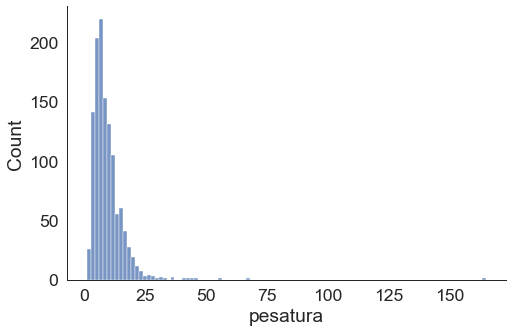

In [20]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="pesatura", kind="hist", bins = 100, aspect = 1.5)

In [21]:
np.mean(quantile(df_dt['pesatura'], 0.99, 0))

8.955601158940398

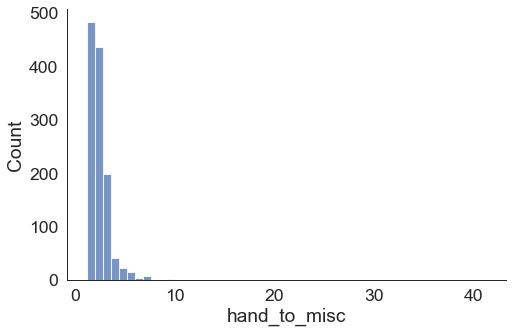

In [22]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="hand_to_misc", kind="hist", bins = 50, aspect = 1.5)

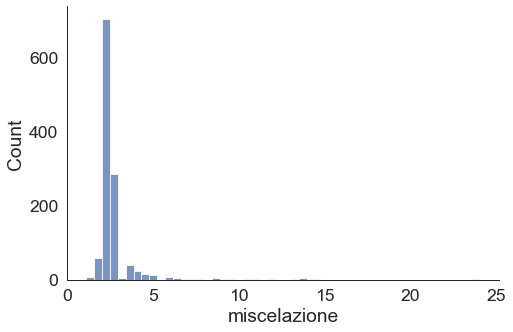

In [23]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="miscelazione", kind="hist", bins = 50, aspect = 1.5)

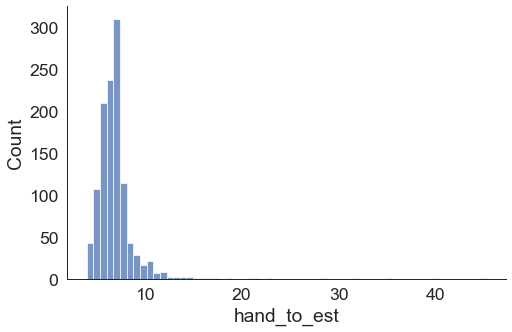

In [30]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="hand_to_est", kind="hist", bins = 60, aspect = 1.5)

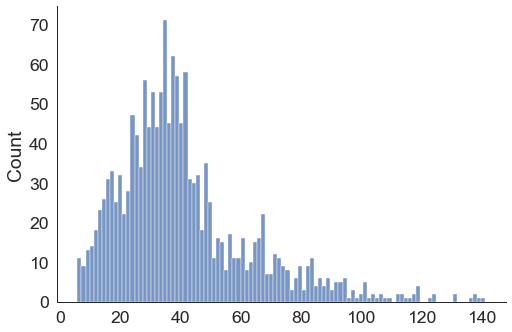

In [31]:
ns = pd.concat([df_dt['estrusione'], df_t_est['est_time']], ignore_index=True)
dt_est = quantile(ns, 0.99, 0.01)
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=dt_est, kind="hist", bins = 100, aspect = 1.5)

### Fitting distributions to data

,sumsquare_error,aic,bic,kl_div
johnsonsu,0.000275,2333.086697,-18660.954047,inf
genextreme,0.000312,2201.949212,-18512.950501,inf
invweibull,0.000312,2201.914761,-18512.941614,inf
genhyperbolic,0.000313,2361.475259,-18495.073270,inf
invgamma,0.000321,2291.000212,-18478.855138,inf


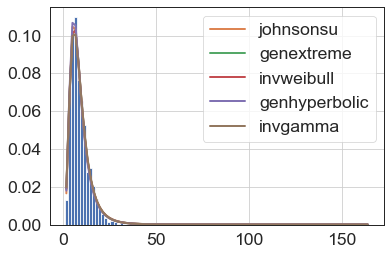

In [32]:
#  extract best fitting distribution from 'pesatura'
#data = quantile(df_dt['pesatura'], 0.99, 0.01)
data = df_dt['pesatura']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [33]:
f.get_best(method = 'sumsquare_error')

{'johnsonsu': {'a': -2.309906114386883,
  'b': 1.5337926656299627,
  'loc': 1.8806498106960001,
  'scale': 2.813651457755295}}

,sumsquare_error,aic,bic,kl_div
cauchy,0.539715,1475.280904,-9416.958879,inf
gumbel_r,0.603206,5851.717080,-9281.163750,inf
wald,0.626071,1929.576531,-9235.736048,inf
hypsecant,0.734263,6118.679020,-9041.103486,inf
laplace,0.793034,5371.924381,-8947.089092,inf


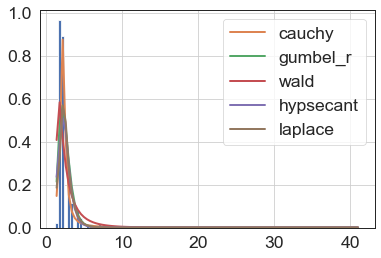

In [40]:
#  extract best fitting distribution from 'handling to misc'
#data = quantile(df_dt['pesatura'], 0.99, 0.01)
data = df_dt['hand_to_misc']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [41]:
f.get_best(method = 'sumsquare_error')

{'cauchy': {'loc': 2.143530320901906, 'scale': 0.3635986753255407}}

,sumsquare_error,aic,bic,kl_div
laplace_asymmetric,3.783245,3358.831250,-6741.673021,inf
gennorm,4.402256,2006.318894,-6563.164633,inf
foldcauchy,4.482564,1632.726446,-6541.868878,inf
dweibull,4.704829,2447.166881,-6484.860318,inf
laplace,4.889084,4003.679399,-6446.678487,inf


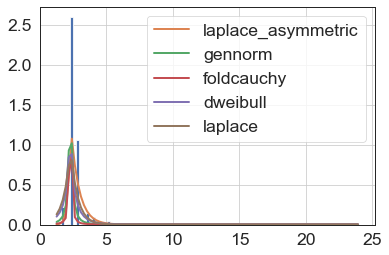

In [34]:
#  extract best fitting distribution from 'miscelazione'
# data = quantile(df_dt['miscelazione'], 0.99, 0.01)
data = df_dt['miscelazione']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [35]:
f.get_best(method = 'sumsquare_error')

{'laplace_asymmetric': {'kappa': 0.5174402731585632,
  'loc': 2.283300000382563,
  'scale': 0.3173758165847843}}

,sumsquare_error,aic,bic,kl_div
cauchy,0.163111,1318.637941,-10432.499530,inf
laplace,0.185926,3011.752436,-10278.542629,inf
laplace_asymmetric,0.214468,2277.001160,-10103.524253,inf
exponnorm,0.222777,2318.415585,-10058.826847,inf
moyal,0.232559,2528.670919,-10015.357658,inf


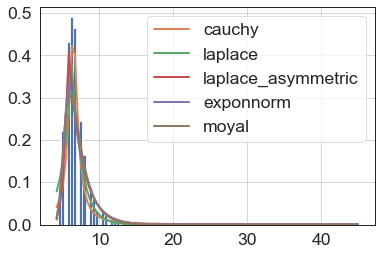

In [36]:
#  extract best fitting distribution from 'handling to estrusore'
#  data = quantile(df_dt['hand_to_est'], 0.99, 0.01)
data = df_dt['hand_to_est']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [37]:
f.get_best(method = 'sumsquare_error')

{'cauchy': {'loc': 6.457168840303545, 'scale': 0.7117884436248214}}

,sumsquare_error,aic,bic,kl_div
laplace,0.000888,1247.341250,-21786.106654,inf
cauchy,0.000953,1211.208888,-21679.922966,inf
gumbel_r,0.000964,1196.698975,-21662.415096,inf
moyal,0.001061,1159.937487,-21516.641248,inf
hypsecant,0.001129,1268.687845,-21422.097133,inf


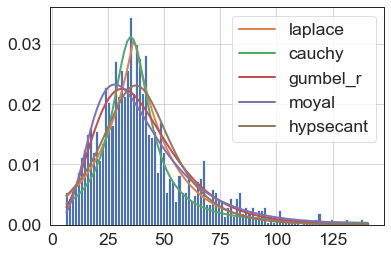

In [38]:
#  extract best fitting distribution from 'estrusione'
f = Fitter(dt_est)
f.fit()
f.summary()

In [39]:
f.get_best(method = 'sumsquare_error')

{'laplace': {'loc': 36.6, 'scale': 15.959097169190258}}

### Tempo totale di attraversamento

In [24]:
def quantile2(column,pct,pct_lower):
    y = column
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return y

In [27]:
def filtering(event_log, ubicazione):
    mask = event_log['rif'] == ubicazione
    get_ID = event_log[mask]['ID_unique'].unique()
    mask_id = event_log['ID_unique'].isin(get_ID)
    new_log = event_log[mask_id]
    return(new_log)

In [28]:
df_est = filtering(df_est, 'P_da_est/estrusore')

tc_list = []
for idu in df_est['ID_unique'].unique():
    mask = df_est['ID_unique'] == idu
    df_tmp = df_est[mask].sort_values('timestamp')
    df_tmp.reset_index(drop=True, inplace=True)
    t1 = df_tmp.loc[0, 'timestamp']
    t2 = df_tmp.loc[len(df_tmp) - 1, 'timestamp']
    tc = ((t2 - t1).seconds)/60
    tc_list.append(tc)

In [119]:
df_tc_sim = pd.read_csv('C:/Users/HP/Desktop/df_tc_sim.csv')

In [120]:
tc_sim = list(df_tc_sim['t_tot'])

In [121]:
len(tc_sim)

1009

In [30]:
tc_list = quantile2(tc_list, 0.98, 0)
tc_list = [x + 2.85 for x in tc_list]
len(tc_list)

1240

In [123]:
tc_sim = tc_sim[(len(tc_sim) - (len(tc_list))):]
len(tc_sim)

373

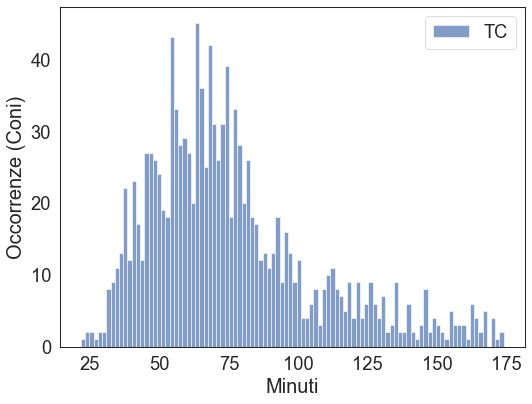

In [45]:
plt.figure(figsize=(8, 6), dpi=75)
plt.hist(tc_list, 100, alpha=0.7, label='TC')
#plt.hist(tc_sim, 50, alpha=0.6, label='TC simulati')
plt.xlabel('Minuti')
plt.ylabel('Occorrenze (Coni)')
plt.legend(loc='upper right')
plt.savefig('C:/Users/HP/Desktop/dist_real_TC.png')
plt.show()

In [125]:
from sklearn.metrics import mean_squared_error
  
# Calculation of Root Mean Squared Error (RMSE)
np.sqrt(mean_squared_error(sorted(tc_list),sorted(tc_sim)))

5.240624642298263

In [127]:
mean_real = np.round(np.mean(tc_list), 2)
mean_sim = np.round(np.mean(tc_sim), 2)
print('Media delle osservazioni reali: {}\nMedia delle osservazioni simulate: {}'.format(mean_real, mean_sim))
print('')
mean_real = np.round(np.median(tc_list), 2)
mean_sim = np.round(np.median(tc_sim), 2)
print('Mediana delle osservazioni reali: {}\nMediana delle osservazioni simulate: {}'.format(mean_real, mean_sim))

Media delle osservazioni reali: 79.77
Media delle osservazioni simulate: 78.15

Mediana delle osservazioni reali: 76.1
Mediana delle osservazioni simulate: 72.3


In [34]:
np.round(np.mean(tc_list), 2)

76.32

In [35]:
np.round(np.median(tc_list), 2)

69.23